# Homework 2

## Import libraries

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt

## Functions

In [2]:
items = set()

"""
Converts a list of transactions into a pandas dataframe with 0s and 1s depending on whether the item is in the transaction or not.
:param transactions: List of transactions (each transaction is a list of items)
"""
def to_dataframe(transactions):
    df = pd.DataFrame(columns=list(items))
    
    for transaction in transactions:
        # Print progress
        if transactions.index(transaction) % 1000 == 0:
            print("Uploading transaction", transactions.index(transaction))

        df.loc[len(df)] = [1 if item in transaction else 0 for item in items]

    return df
    
"""
Loads the sample dataset
"""
def load_sample_dataset(real=False):
    global items

    # Real dataset
    if real:
        transactions = pd.read_csv('data/dummy_transactions.dat', header=None)
        transactions = transactions.values.tolist()
        _transactions = []

        for transaction in transactions:
            list_transaction = []
            for item in transaction:
                for single_item in item.rstrip().split(' '):
                    list_transaction.append(single_item)
                    items.add(single_item) # We iterate each element for each of the baskets and add it to the set of items
            _transactions.append(list_transaction)
    else:
        # Dummy dataset
        _transactions = [
            ['Bread', 'Milk'],
            ['Bread', 'Diapers', 'Beer', 'Eggs'],
            ['Milk', 'Diapers', 'Beer', 'Cola'],
            ['Bread', 'Milk', 'Diapers', 'Beer'],
            ['Bread', 'Milk', 'Diapers', 'Cola']
        ]
        for transaction in _transactions:
            for item in transaction:
                items.add(item)

    return _transactions

"""
Apriori algorithm for finding frequent itemsets
:param transactions: Dataframe of transactions (each transaction is a list of items)
:param min_support: Minimum support threshold
:return: Dictionary of frequent itemsets with their support
"""
def apriori(transactions, min_support):

    L = dict() # Candidate k-itemsets

    # Function to get itemsets of a given size
    """
    Gets the possible itemsets for a given size
    :param transactions: List of transactions (each transaction is a list of items)
    :param size: Size of the itemsets to generate
    """
    def get_new_itemsets(k):
        next_itemsets = set()

        if k == 1:
            for elem in list(transactions.columns):
                next_itemsets.add((elem, )) # Add tuple of one element
        else:
            # We augment the dimension of each of the previous k-1-frequent itemsets with each of the 1-frequent itemsets
            for itemset in L[k-1].keys():
                for item in L[1].keys():
                    if item[0] not in list(itemset):
                        new_itemset = tuple(sorted(list(itemset) + list(item)))
                        next_itemsets.add(new_itemset)

        return next_itemsets


    """
    Calculates the support for each itemset in the list of itemsets. Counting how many times one itemset appears in all transactions.
    :param itemsets: Set of itemsets (each itemset is a tuple of items)
    :return: Dictionary of itemsets with their support
    """
    # Function to calculate support for itemsets
    def calculate_support(itemsets):
        supports = {}

        for itemset in itemsets:
            relevant_df = pd.DataFrame(transactions[list(itemset)]) # Select columns of the itemset
            support_count = (relevant_df.sum(axis=1) == len(itemset)).sum() # Count how many rows have 1s everywhere (support)
            supports[itemset] = support_count

        return supports

    # =========================================================================================
    # Main part of the algorithm
    k = 1  # Starting with 1-itemsets
    L[k] = dict() # Frequent k-itemsets
    next_itemsets = get_new_itemsets(k) # Candidate k-itemsets
    # print("Next itemsets:", next_itemsets)

    # Loop through each level (single items, pairs, triples, etc.)
    while next_itemsets:
        # print("k:", k)
        
        itemset_support = calculate_support(next_itemsets) # Calculate support for each itemset
        # print("Support:", itemset_support)

        L[k] = {itemset: support for itemset, support in itemset_support.items() if support >= min_support} # Select itemsets with support greater or equal to min_support
        # print("L[k]:", L[k])

        k += 1 # Next level
        L[k] = dict()
        next_itemsets = get_new_itemsets(k) # Generate candidate itemsets for the next level

    return L



## Runnning on the dataset

In [3]:
# Create and save dataset
to_dataframe(load_sample_dataset(real=False)).to_csv('data/transactions.csv', index=False)

Uploading transaction 0


In [4]:
# Read dataset
df_transactions = pd.read_csv('data/transactions.csv')
df_transactions

,Milk,Bread,Beer,Eggs,Cola,Diapers
0,1,1,0,0,0,0
1,0,1,1,1,0,1
2,1,0,1,0,1,1
3,1,1,1,0,0,1
4,1,1,0,0,1,1


In [5]:
# Safety check: how many ones are there in the dataset?
df_transactions.sum().sum()

18

In [6]:
timing = [] # Track timing for each dataset size

support = [2, 3, 4, 5, 6, 7, 8, 9, 10] # Support thresholds to test
sizes = [10, 100, 1000, 2000, 3000, 4000]

for size in sizes:
    print("Size:", size)
    # TODO: for s in support
    start_time = time.time()
    L = apriori(df_transactions[:size], support[0])
    for k in L.keys():
        print("L[{}]: {}".format(k, L[k]))
    end_time = time.time()
    timing.append((size, end_time - start_time))

timing

Size: 10
L[1]: {('Bread',): 4, ('Milk',): 4, ('Beer',): 3, ('Cola',): 2, ('Diapers',): 4}
L[2]: {('Bread', 'Milk'): 3, ('Cola', 'Diapers'): 2, ('Diapers', 'Milk'): 3, ('Beer', 'Diapers'): 3, ('Beer', 'Bread'): 2, ('Cola', 'Milk'): 2, ('Bread', 'Diapers'): 3, ('Beer', 'Milk'): 2}
L[3]: {('Beer', 'Diapers', 'Milk'): 2, ('Cola', 'Diapers', 'Milk'): 2, ('Beer', 'Bread', 'Diapers'): 2, ('Bread', 'Diapers', 'Milk'): 2}
L[4]: {}
L[5]: {}
Size: 100
L[1]: {('Bread',): 4, ('Milk',): 4, ('Beer',): 3, ('Cola',): 2, ('Diapers',): 4}
L[2]: {('Bread', 'Milk'): 3, ('Cola', 'Diapers'): 2, ('Diapers', 'Milk'): 3, ('Beer', 'Diapers'): 3, ('Beer', 'Bread'): 2, ('Cola', 'Milk'): 2, ('Bread', 'Diapers'): 3, ('Beer', 'Milk'): 2}
L[3]: {('Beer', 'Diapers', 'Milk'): 2, ('Cola', 'Diapers', 'Milk'): 2, ('Beer', 'Bread', 'Diapers'): 2, ('Bread', 'Diapers', 'Milk'): 2}
L[4]: {}
L[5]: {}
Size: 1000
L[1]: {('Bread',): 4, ('Milk',): 4, ('Beer',): 3, ('Cola',): 2, ('Diapers',): 4}
L[2]: {('Bread', 'Milk'): 3, ('Cola',

[(10, 0.017467737197875977),
 (100, 0.01502084732055664),
 (1000, 0.01516270637512207),
 (2000, 0.014358043670654297),
 (3000, 0.014736175537109375),
 (4000, 0.014210224151611328)]

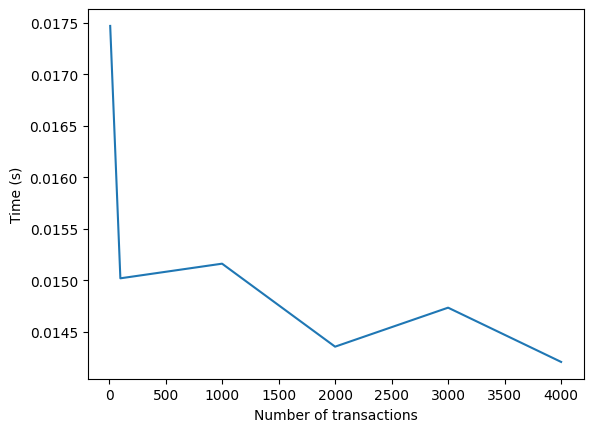

In [7]:
# Plot timing
plt.plot([x[0] for x in timing], [x[1] for x in timing])
plt.xlabel('Number of transactions')
plt.ylabel('Time (s)')
plt.show()
